<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/CaLNG_demand_with_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product


# control the figure size
plt.rcParams["figure.figsize"] = (20,3)

In [3]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [7]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [4]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Q1

In [9]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    usage_data = demand_data.copy()
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})
    
    usage_data['pipeline_price'] = np.exp(np.maximum(0, (usage_data['Demand'] - 144) / 60))
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = np.maximum(usage_data['Demand'] - peak_intake_from_pipeline, 0)
    usage_data['purchase_from_calng'] = np.minimum(usage_data['demand_for_lng'], total_lng_intake - usage_data['demand_for_lng'].cumsum().shift(fill_value=0))
    
    usage_data['pipeline_intake'] = usage_data['Demand'] - usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = np.exp(np.maximum(0, (usage_data['pipeline_intake'] - 144) / 60))
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']
    
    return usage_data

def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase * calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    
    avg_cost = np.mean(cost_data['cost_from_both']) * 1000
    std_dev = np.std(cost_data['cost_from_both']) * 1000
    
    return total_utility_cost, avg_cost, std_dev

def find_optimal_parameters(demand_data, calng_price, total_lng_range, peak_intake_range):
    best_cost = float('inf')
    best_params = None
    
    for total_lng, peak_intake in product(total_lng_range, peak_intake_range):
        usage_data = determine_actual_usage(demand_data, calng_price, peak_intake, total_lng)
        cost, _, _ = calculate_cost_statistics(usage_data, calng_price, peak_intake, total_lng)
        
        if cost < best_cost:
            best_cost = cost
            best_params = (total_lng, peak_intake)
    
    return best_params, best_cost
    

## check

In [57]:
df1 = determine_actual_usage(demand_data, 7.5, 180, 1000)
df1.head()

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.000000,94.000000,0,0,94,1.000000,94.000000,0.000000
1,1,December,2,304,14.391916,4375.142493,124,124,180,1.822119,1257.981384,3117.161109
2,2,December,3,70,1.000000,70.000000,0,0,70,1.000000,70.000000,0.000000
3,3,December,4,222,3.669297,814.583860,42,42,180,1.822119,642.981384,171.602476
4,4,December,5,123,1.000000,123.000000,0,0,123,1.000000,123.000000,0.000000


## Globally optimal solution

In [31]:
calng_price = 7.50
total_lng_range =range(700, 1300, 2)
peak_intake_from_pipeline_range = range(170,200)

In [37]:
optimal_params, optimal_cost = find_optimal_parameters(demand_data, calng_price, total_lng_range, peak_intake_from_pipeline_range)
print(f"Optimal (total_LNG, peak_intake_from_pipeline): {optimal_params} with cost: ${optimal_cost:,.2f}")

Optimal (total_LNG, peak_intake_from_pipeline): (1288, 181) with cost: $28,123,574.92


## Optimal solution under given scenarios:

In [40]:
calng_price = 7.50
total_lng_range =range(700, 1300, 50)
peak_intake_from_pipeline_range = range(170, 200, 5)
optimal_params, optimal_cost = find_optimal_parameters(demand_data, calng_price, total_lng_range, peak_intake_from_pipeline_range)
print(f"Optimal (total_LNG, peak_intake_from_pipeline): {optimal_params} with cost: ${optimal_cost:,.2f}")

Optimal (total_LNG, peak_intake_from_pipeline): (1150, 185) with cost: $28,244,451.28


## A quicker algorithm

In [45]:
from scipy.optimize import differential_evolution

def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    usage_data = demand_data.copy()
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})
    
    usage_data['pipeline_price'] = np.exp(np.maximum(0, (usage_data['Demand'] - 144) / 60))
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = np.maximum(usage_data['Demand'] - peak_intake_from_pipeline, 0)
    usage_data['purchase_from_calng'] = np.minimum(usage_data['demand_for_lng'], total_lng_intake - usage_data['demand_for_lng'].cumsum().shift(fill_value=0))
    
    usage_data['pipeline_intake'] = usage_data['Demand'] - usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = np.exp(np.maximum(0, (usage_data['pipeline_intake'] - 144) / 60))
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']
    
    return usage_data

def calculate_cost_statistics(usage_data, calng_price, total_lng_purchase):
    total_pipeline_intake_cost = (usage_data['pipeline_intake'] * usage_data['pipeline_intake_price']).sum() * 1000
    total_calng_intake_cost = total_lng_purchase * calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    
    return total_utility_cost

def optimize_parameters(demand_data, calng_price, total_lng_bounds, peak_intake_bounds):
    bounds = [total_lng_bounds, peak_intake_bounds]

    def objective(params):
        total_lng, peak_intake = params
        total_lng, peak_intake = int(round(total_lng)), int(round(peak_intake))
        usage_data = determine_actual_usage(demand_data, calng_price, peak_intake, total_lng)
        return calculate_cost_statistics(usage_data, calng_price, total_lng)

    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=50, popsize=15, tol=0.01)
    initial_total_lng, initial_peak_intake = int(round(result.x[0])), int(round(result.x[1]))

    total_lng_range = range(max(initial_total_lng - 10, total_lng_bounds[0]), min(initial_total_lng + 10, total_lng_bounds[1]) + 1)
    peak_intake_range = range(max(initial_peak_intake - 3, peak_intake_bounds[0]), min(initial_peak_intake + 3, peak_intake_bounds[1]) + 1)

    best_cost = float('inf')
    best_params = None

    for total_lng, peak_intake in product(total_lng_range, peak_intake_range):
        usage_data = determine_actual_usage(demand_data, calng_price, peak_intake, total_lng)
        cost = calculate_cost_statistics(usage_data, calng_price, total_lng)

        if cost < best_cost:
            best_cost = cost
            best_params = (total_lng, peak_intake)

    return best_params, best_cost

calng_price = 7.50
total_lng_bounds = (700, 1300)
peak_intake_bounds = (170, 200)

optimal_params, optimal_cost = optimize_parameters(demand_data, calng_price, total_lng_bounds, peak_intake_bounds)
print(f"Optimal (total_LNG, peak_intake_from_pipeline): {optimal_params} with cost: ${optimal_cost:,.2f}")

Optimal (total_LNG, peak_intake_from_pipeline): (1288, 181) with cost: $28,123,574.92


# Q2

In [5]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [7]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [9]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

In [11]:
from joblib import Parallel, delayed  

# number of simulation draws per scenario
num_draws = 5000

# decision variables
calng_price = 7.50
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range = range(170, 200, 5)

cost_stat_list = []

def run_simulation(peak, total):
    demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(demand_data)))
    demand_sample = np.where(demand_sample < 0, 0, demand_sample)

    sim_usage_data = determine_actual_usage(
        pd.DataFrame({'Demand': demand_sample}), calng_price, peak, total
    )
    return calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = Parallel(n_jobs=-1)(delayed(run_simulation)(peak, total) for _ in range(num_draws))

        sims_array = np.array([list(sim.values()) for sim in sims])
        column_names = list(sims[0].keys())

        mean_values = np.mean(sims_array, axis=0)
        std_values = np.std(sims_array, axis=0)

        mean_values_dict = dict(zip(column_names, mean_values))
        mean_values_dict["total_utility_cost_std"] = std_values[column_names.index("total_utility_cost")]

        cost_stat_list.append(mean_values_dict)

df1 = pd.DataFrame(cost_stat_list)

In [13]:
df1 = df1.round(0)
df1.head()

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily,total_utility_cost_std
0,170.0,700.0,12415.0,699.0,21719896.0,5250000.0,26969896.0,4565172.0,13733475.0,4660459.0
1,175.0,700.0,12420.0,694.0,21087304.0,5250000.0,26337304.0,5225491.0,13729161.0,4601811.0
2,180.0,700.0,12434.0,681.0,20451739.0,5250000.0,25701739.0,5944126.0,13729856.0,4173629.0
3,185.0,700.0,12480.0,656.0,20169681.0,5250000.0,25419681.0,6599101.0,13788822.0,3668141.0
4,190.0,700.0,12499.0,610.0,19965976.0,5250000.0,25215976.0,6956967.0,13714335.0,2966405.0


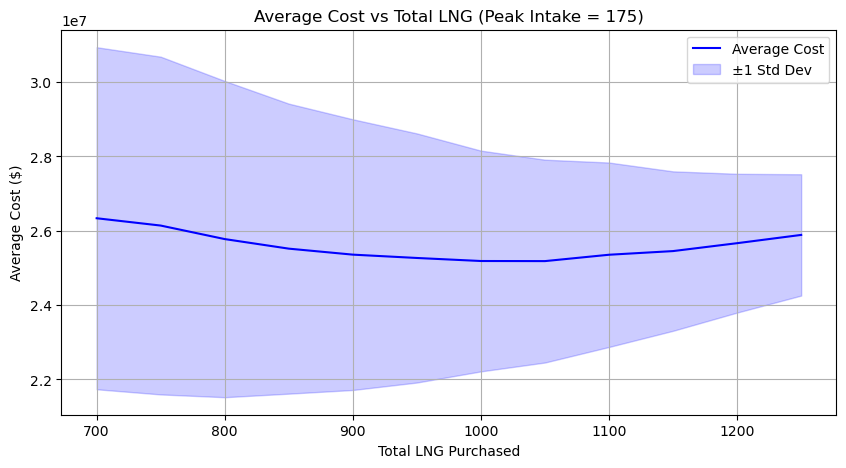

In [35]:
df_lng = df1[df1['peak_intake_from_pipeline'] == 175]

plt.figure(figsize=(10, 5))
plt.plot(df_lng['total_lng_purchase'], df_lng['total_utility_cost'], label="Average Cost", color='b')
plt.fill_between(df_lng['total_lng_purchase'], 
                 df_lng['total_utility_cost'] - df_lng['total_utility_cost_std'], 
                 df_lng['total_utility_cost'] + df_lng['total_utility_cost_std'], 
                 color='b', alpha=0.2, label="±1 Std Dev")

plt.xlabel("Total LNG Purchased")
plt.ylabel("Average Cost ($)")
plt.title("Average Cost vs Total LNG (Peak Intake = 175)")
plt.legend()
plt.grid()
plt.show()

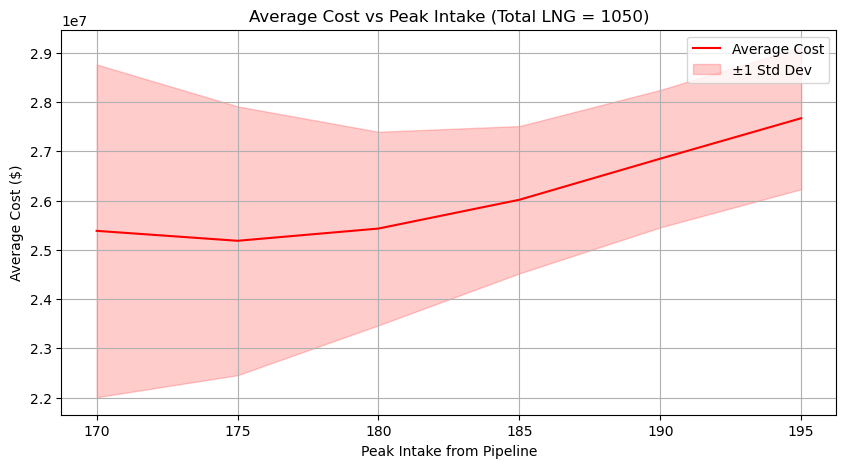

In [33]:
df_peak = df1[df1['total_lng_purchase'] == 1050]

plt.figure(figsize=(10, 5))
plt.plot(df_peak['peak_intake_from_pipeline'], df_peak['total_utility_cost'], label="Average Cost", color='r')
plt.fill_between(df_peak['peak_intake_from_pipeline'], 
                 df_peak['total_utility_cost'] - df_peak['total_utility_cost_std'], 
                 df_peak['total_utility_cost'] + df_peak['total_utility_cost_std'], 
                 color='r', alpha=0.2, label="±1 Std Dev")

plt.xlabel("Peak Intake from Pipeline")
plt.ylabel("Average Cost ($)")
plt.title("Average Cost vs Peak Intake (Total LNG = 1050)")
plt.legend()
plt.grid()
plt.show()